# Project 3: Web APIs & NLP
## Reddit.com/r/workplacesitcoms 
#### By: Danielle Medellin [GitHub](https://github.com/dmedellin2)

## Table of Contents:
- [Problem Statement](#Problem-Statement)  
- [Executive Summary](#Executive-Summary)  
    - [Data Dictionary](#Data-Dictionary)
- [Data Import](#Data-Import)  
- [Data Cleaning](#Data-Cleaning)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Stop Words](#Looking-at-Top-100-Words-Overlap-to-Create-Stop-Words)
- [Modeling](#Modeling)
    - [Model Preparation](#Model-Preparation)
    - [Baseline Model](#Baseline-Model)
    - [Logistic Regression](#Logistic-Regression)
    - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
    - [k-Nearest Neighbors](#k-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Bagging Classifier](#Bagging-Classifier)
    - [Support Vector Machine](#Support-Vector-Machine)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-&-Recommendations)

## Problem Statement 
[Top](#Table-of-Contents:)

NBC is looking to see how people engage with some of their most famous sitcoms on various social media platforms. One of these platforms is Reddit. An intern at NBC was tasked with gathering as many posts as he could from subreddits for NBC sitcoms like _Will & Grace, The Office, Parks and Recreation, Brooklyn 99_, and _The Good Place_. Unfortunately, this intern was terrible at organization and dumped all of the posts he found into one general folder. NBC has been working to properly separate all of the posts into their TV show groups. Most of the posts were able to be separated, but two shows remain: _The Office_ and _Parks and Recreation_.  

It is so difficult to separate the posts between these two shows because they share a lot of similarities. For starters, they share some of the same creators including Greg Daniels and Michael Schur. Both shows are considered workplace comedies as they take place at either a paper company or a government office. While both shows started and ended in different years, they had many years of overlap where both were actively on the air. Additionally, the two shows share some character names and even an actor! For example, both shows include a character named 'Andy' and Rashida Jones played a consistent role in both TV shows. Looking at crossover between character names and actor names, we get even more commonalities, for example the character 'Michael Scott' from _The Office_ and the actor Adam Scott, who plays a main role in _Parks and Recreation_.  

Due to the many similarities between these two shows, NBC came to us to help them sort through the posts and separate them back into their appropriate subreddits: _The Office_ -- r/DunderMifflin, and _Parks and Recreation_ -- r/PandR.  

Additionally, NBC is also interested in what content helped made it possible to differentiate between the two shows and what Reddit users are talking about the most in each of the subreddits.  

We will build a classification model that will help to sort each post to its appropriate subreddit. Our model's success will be measured with an accuracy score.

## Executive Summary
[Top](#Table-of-Contents:)

Blah blah blahdhslkf

### Data Dictionary


|Feature|Type|Description|
|:---|:---:|:---|
|title|object|The title of the Reddit submission|
|selftext|object|Additional text about the post (optional)|
|subreddit|int|A 0 indicates r/DunderMiffilin, a 1 indicates r/PandR|
|author|object|Username of submission author|
|num_comments|int|Number of comments on that submission|
|score|int|A comment's score is the number of upvotes minus the number of downvotes|
|timestamp|datetime|The date of submission|




The data: 
What is the score?   https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F

## Data Import
[Top](#Table-of-Contents:)  
In the _data_gathering_ notebook, one can view the process for using the reddit API to collect posts from the r/DunderMifflin and r/PandR subreddits over the course of the past 10 years. Both subreddits were created in January of 2011.

### Importing Libraries
[Top](#Table-of-Contents:)

In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.svm import SVC


import warnings
# warnings.filterwarnings("ignore") 

In [650]:
# read in the data
reddit = pd.read_csv('../data/reddit.csv')
reddit.drop(columns=['created_utc','is_self'],inplace=True)

In [651]:
# check dataframe
reddit.head(2)

,title,selftext,subreddit,author,num_comments,score,timestamp
0,Letter to Brendanawicz,This guy had no chance. He started out being c...,PandR,RandySwango,4,18,2019-10-17
1,Just started watching the show on Amazon Prime...,At least on season two as I've noticed the sub...,PandR,Oo00oOo00oOO,0,1,2019-10-17


## Data Cleaning
[Top](#Table-of-Contents:)

In [652]:
# check the shape of the data
reddit.shape

(4675, 7)

Our `reddit` dataframe includes 4675 reddit posts, each with 7 features.

In [653]:
# checking for null values
reddit.isnull().sum()

title             0
selftext        570
subreddit         0
author            0
num_comments      0
score             0
timestamp         0
dtype: int64

The only column with null values is the `selftext` column, which we will not be using in analysis. For text analysis, we will focus on the title column only.

In [654]:
reddit.dtypes

title           object
selftext        object
subreddit       object
author          object
num_comments     int64
score            int64
timestamp       object
dtype: object

Being most of our data in the dataframe is text, most data types should be 'object'. We will convert the `timestamp` column into datetime. Currently, the `subreddit` column has the name of the subreddit the submission came from, but we will turn that into a binary classification where 0 means r/DunderMifflin (_The Office_) and 1 means r/PandR (_Parks and Recreation_).

In [655]:
reddit['subreddit'].value_counts()

DunderMifflin    2626
PandR            2049
Name: subreddit, dtype: int64

In [656]:
# casting subreddit as 0,1 0 = Office, 1 = P and R
reddit['subreddit'] = [1 if entry == 'PandR' else 0 for entry in reddit['subreddit']]

In [657]:
# confirming value counts
reddit['subreddit'].value_counts()

0    2626
1    2049
Name: subreddit, dtype: int64

In [658]:
# changing timestamp to a datetime object
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])

In [659]:
reddit.dtypes

title                   object
selftext                object
subreddit                int64
author                  object
num_comments             int64
score                    int64
timestamp       datetime64[ns]
dtype: object

In [660]:
reddit.describe()

,subreddit,num_comments,score
count,4675.000000,4675.000000,4675.000000
mean,0.438289,7.761711,17.507594
std,0.496230,21.852437,338.446323
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,4.000000,4.000000
75%,1.000000,9.000000,10.000000
max,1.000000,1180.000000,22726.000000


Statistics for the `subreddit` column make sense as the max is 1 and the min is 0. Looking at the quartlies and maximum for the `num_comments` column, it appears that there may be outliers in the data since the maximum is so far from the 75th percentile. Similarly, for the `score` column, the range from the minimum to the 75th percentile is 0 - 10, but the jump from the 75th percentile to the maximum is much greater with a maximum of 22726. Again, this shows that there may be outliers in the data. 

In [661]:
reddit.groupby('subreddit').describe().T

subreddit                      0            1
num_comments count   2626.000000  2049.000000
             mean       9.064356     6.092240
             std       27.013042    12.230085
             min        0.000000     0.000000
             25%        2.000000     1.000000
             50%        5.000000     3.000000
             75%       10.000000     7.000000
             max     1180.000000   229.000000
score        count   2626.000000  2049.000000
             mean      19.471059    14.991215
             std      448.979861    55.062774
             min        0.000000     0.000000
             25%        1.000000     1.000000
             50%        3.000000     4.000000
             75%        9.000000    11.000000
             max    22726.000000  1105.000000

Separating the data by subreddit, we can see that the r/DunderMifflin subreddit has higher maximums for both the `score` and `num_comments` columns. 

In [663]:
# sorting df by `num_comments`
reddit.sort_values('num_comments', ascending=False).head()

,title,selftext,subreddit,author,num_comments,score,timestamp
2373,The day they take The Office off of Netflix is...,NaN,0,RonThunderfist,1180,22726,2018-04-26
4195,"SO9EO9 ""Dwight Christmas"" Episode Discussion","From Wikipedia: \n\n""When the party planning c...",0,Prefer_an_astronaut,253,55,2012-12-06
4173,"SO9EO8 ""The Target"" Discussion Thread","From Wikipedia:\n\n""Angela goes to Dwight for ...",0,Prefer_an_astronaut,236,56,2012-11-29
1521,"Parks And Recreation S06E08/09 ""Fluoride"" / ""T...",####Two new episodes again tonight! \n\n\n---\...,1,atticus138,229,111,2013-11-21
863,Has anyone found another comedy that gives the...,The only one was the office. I felt attached t...,1,andrew9360,210,185,2016-06-14


After visually exploring the data a bit, we see there is an outlier in the `num_comments` column. We will drop the row with 1180 comments.

In [664]:
reddit.drop([2373],inplace=True)

In [665]:
# sorting df by `score`
reddit.sort_values('score', ascending=False).head()

,title,selftext,subreddit,author,num_comments,score,timestamp
3605,Found the best way to watch The Office,First make sure you have enough time to watch ...,0,Dan_Ashcroft,90,2540,2014-11-19
3083,"It is me, Rainn Wilson (that guy from The Offi...",At 1pm (PDT) I’ll be on the @SoulPancake snapc...,0,IAmRainnWilson,105,2419,2016-05-19
1382,Why Jerry is without a doubt the best characte...,"lol jk, you're the worst Jerry!",1,radslacker,100,1105,2014-12-30
769,"I can never, ever read ""treat yoself"" or ""trea...","And yes, I have treated myself more.",1,geetannn,37,840,2016-12-29
964,"Just realized that Leslie, Ann, &amp; Tom all ...",I'm sure someone else has already pointed this...,1,MooCow93,51,748,2016-07-30


After visually exploring the data a bit, we see there are some outliers in the `score` column. We will drop the rows with scores of more than 2000.

In [666]:
reddit = reddit[reddit['score']<2000]

## Exploratory Data Analysis
[Top](#Table-of-Contents:)

In [667]:
# function for creating boxplots
def new_boxplot(data,x,y,title,xlabel,ylabel,palette):
    plt.figure(figsize=(7,6))
    sns.boxplot(data=data, x=y, y=x, palette=palette)
    plt.title(title,size=15)
    plt.xlabel(xlabel,size=12)
    plt.ylabel(ylabel,size=12);

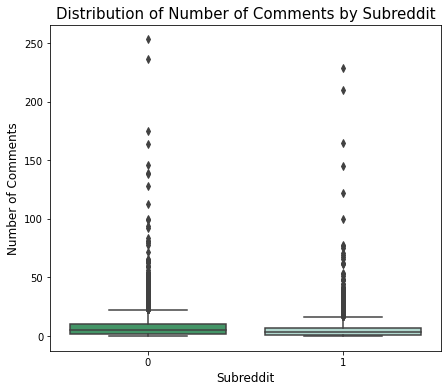

In [668]:
new_boxplot(reddit, 'num_comments','subreddit','Distribution of Number of Comments by Subreddit','Subreddit','Number of Comments','BuGn_r')

The majority of the data for both subreddits has less than 25 comments per post. The maximum amount of comments for both subreddits reaches around 230-250. Both subreddits have similar distributions, but the quartiles and maximum for _The Office_ (0) subreddit are generally higher than those of the _Parks and Recreation_ (1) subreddit. Given the similarities in the distributions, it is unclear if the number of comments per post will be a helpful predictive feature in our model.

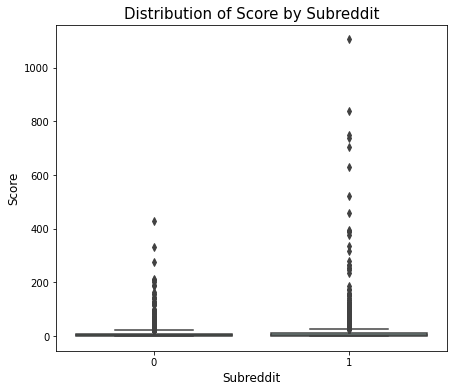

In [669]:
new_boxplot(reddit, 'score','subreddit','Distribution of Score by Subreddit','Subreddit','Score','BuGn_r')

The majority of the scores of posts for both subreddits is from 0-30. Both subreddits have scores that fall outside that range. The maximum for _The Office_ (0) subreddit falling around 450, and the maximum for the _Parks and Recretaion_ (1) subreddit falling beyond 1000. There are many more posts with scores of 200 or more for the _Parks and Recreation_ subreddit as opposed to _The Office_ subreddit. Looking at the Score for each post might be a helpful predictive feature in the model. 

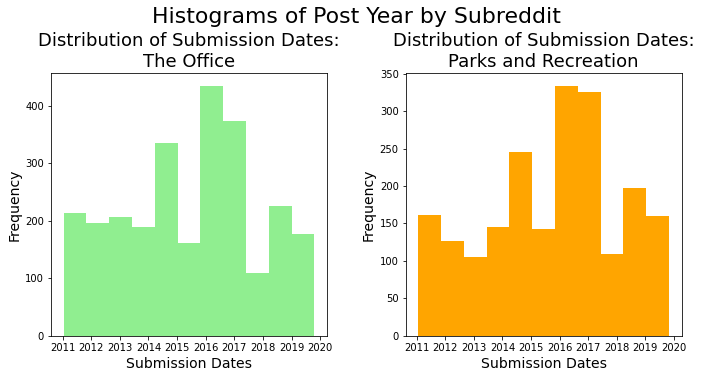

In [672]:
cols = [0,1] # diff subreddits 

fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)

fig.suptitle("Histograms of Post Year by Subreddit", fontsize = 22, y = 1.04)

axes = axes.flatten()

color = ['lightgreen', 'orange']

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(reddit[reddit['subreddit']==col]['timestamp'],color=color[i],bins=11)
    ax.set_ylabel("Frequency",size=14)
    readable_col = ['The Office','Parks and Recreation']
    ax.set_xlabel('Submission Dates',size=14)
    ax.set_title(f"Distribution of Submission Dates:\n{readable_col[i]}",size=18)
    
plt.tight_layout();

We pulled data in intervals of every 6 months for the past 10 years from both subreddits. Both of these subreddits began in January of 2011. The two subreddits have similar distributions with peaks around 2016-2017. These are years that both of the shows were already off air. Neither subreddit seems to fall below 100 posts in a specific time range. Surprisingly, the most recent time range has a similar amount of posts as the first time range. Both subreddits show a similar distribution meaning using the `timestamp` feature might not be useful for our model. 

In [673]:
# creating count vectorizer to look at frequent words
cvec = CountVectorizer()
X_text = reddit['title'] # grabbing just the titles 

In [674]:
# count vectorizing and put in dataframe
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

In [675]:
# grabbing top 30 most common words
top_words = X_text_df.sum().sort_values(ascending=False)[:30]

In [676]:
top_words

the        2346
and         847
to          838
is          750
of          727
in          677
what        496
you         447
season      414
episode     412
office      402
for         396
that        388
just        370
it          337
on          315
this        278
show        274
was         273
anyone      271
have        260
michael     254
with        231
from        219
my          218
how         207
does        205
about       204
do          194
can         193
dtype: int64

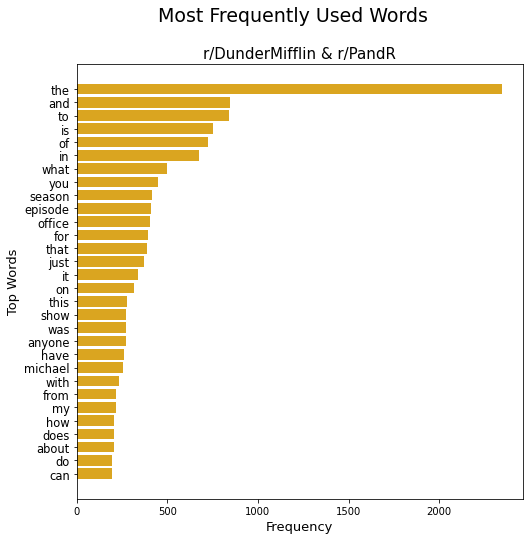

In [678]:
plt.figure(figsize=(8,8))
plt.barh(y=top_words.index[::-1],width=top_words[::-1],color='goldenrod')
plt.suptitle('Most Frequently Used Words',size=19)
plt.title('r/DunderMifflin & r/PandR',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Words',size=13)
plt.yticks(size=11.5);

Above are the top 30 most frequently used words found in both subreddits combined. Most of these words are general filler words that do not give us much meaning like `the`, `of`, and `with`. Some of them make sense given that our two subreddits are focused on television shows, like `episode`, `show`, and `season`. Only two of these words stick out to us as being possibly important words that could help determine which subreddit a post is from: `office` and `michael`. The reason for that is because the r/DunderMifflin subreddit is about the show _The Office_ and the main character of that show is Michael Scott. Given these facts it is expected that the words `office` and `michael` would show up frequently in the posts of that subreddit. 

In [679]:
# creating list of possible stop words
poss_stopwords = list(top_words.index)

In [680]:
poss_stopwords.remove('michael')

In [681]:
poss_stopwords.remove('office')

In [682]:
print(len(poss_stopwords))
poss_stopwords

28


['the',
 'and',
 'to',
 'is',
 'of',
 'in',
 'what',
 'you',
 'season',
 'episode',
 'for',
 'that',
 'just',
 'it',
 'on',
 'this',
 'show',
 'was',
 'anyone',
 'have',
 'with',
 'from',
 'my',
 'how',
 'does',
 'about',
 'do',
 'can']

We have taken the list of the top 30 most frequent words from above, removed `michael` and `office`, and kept it as a list of possible stop words. When creating our model later, we will want to focus on the most frequently used words. If the majority of our most frequently used words are words like `the`, `for`, and `can`, our model will not be great at classifiying the posts into the correct subreddit. Thus, we will test the use of this list as our list of stop words in our models later. 

In [683]:
# get text from just the office subreddit
off_text = reddit[reddit['subreddit']==0]['title']

In [684]:
# count vectorize office text
cvec = CountVectorizer()
off_text = cvec.fit_transform(off_text)
off_text_df = pd.DataFrame(off_text.toarray(), columns = cvec.get_feature_names())

In [685]:
# get text from just parks and rec subreddit
parks_text = reddit[reddit['subreddit']==1]['title']

In [686]:
# count vectorize parks and rec subreddit 
cvec = CountVectorizer()
parks_text = cvec.fit_transform(parks_text)
parks_text_df = pd.DataFrame(parks_text.toarray(), columns = cvec.get_feature_names())

In [687]:
# top 30 most frequent words in office subreddit
off_top = off_text_df.sum().sort_values(ascending=False)[:30]

In [688]:
# top 30 most frequent words in parks and rec subreddit
parks_top = parks_text_df.sum().sort_values(ascending=False)[:30]

In [689]:
# looking at the overlap in the top 30 of each individual subreddit 
overlap = set(off_top.index).intersection(set(parks_top.index))
print(len(overlap))
overlap

21


{'and',
 'anyone',
 'episode',
 'for',
 'have',
 'in',
 'is',
 'it',
 'just',
 'of',
 'on',
 'season',
 'show',
 'that',
 'the',
 'this',
 'to',
 'was',
 'what',
 'with',
 'you'}

We looked at the top 30 most frequently occurring words in the titles of submissions from each subreddits individually. After looking at the intersection of those two sets of words, it was found that 21 words were shared by both subreddits. Most of these words are 'filler' words like `for`, `just`, `and`, `that`, and `the` which don't give us much information. Words that make sense for these subreddits are `show`, `epsiode` and `season`, but because both subreddits are focused on television shows, they don't help to distinguish between the two.  


In [690]:
# finding words that are only in the parks top 30
parks_only = set(parks_top.index) - set(off_top.index)
parks_only

{'can', 'does', 'how', 'leslie', 'me', 'my', 'parks', 'rec', 'ron'}

In [691]:
# finding words that are only in the office top 30
off_only = set(off_top.index) - set(parks_top.index)
off_only

{'about', 'do', 'dwight', 'from', 'jim', 'michael', 'office', 'pam', 'your'}

In [692]:
# getting frequency for just the unique office words
off_top_words = off_text_df[off_only].sum().sort_values(ascending=False)[:30]

In [693]:
# # getting frequency for just the unique parks and rec words
parks_top_words = parks_text_df[parks_only].sum().sort_values(ascending=False)[:30]

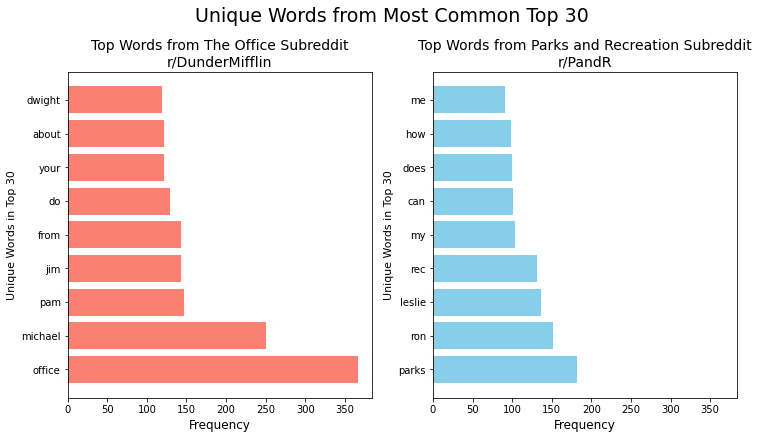

In [695]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6), sharex=True) # unpack graphs
# add title to entire figure
fig.suptitle("Unique Words from Most Common Top 30", fontsize = 19, y = 1.03) 

ax1.barh(y=off_top_words.index,width=off_top_words,color='salmon') 
ax2.barh(y=parks_top_words.index,width=parks_top_words,color='skyblue')
ax1.set_title('Top Words from The Office Subreddit\nr/DunderMifflin',size=14)
ax2.set_title('Top Words from Parks and Recreation Subreddit\nr/PandR',size=14)
ax1.set_xlabel('Frequency',size=12)
ax2.set_xlabel('Frequency',size=12)
ax1.set_ylabel('Unique Words in Top 30', size=11)
ax2.set_ylabel('Unique Words in Top 30', size=11);

We looked at the top 30 most frequently occurring words in the titles of both subreddits. After looking at the intersection of those two sets of words, it was found that 21 of those words were shared by both subreddits. 

We separated out the **unique** words for each subreddit's top 30 and plotted their frequencies above. Still there are some words that don't give us much information such as `your`, `do`, `from`, `my`, `can`, and `how`, but we also notice some other words that stand out. For the _The Office_ subreddit some of the top words include `office`, `michael`, `pam`, `jim`, and `dwight`. While `office` may seem like a mundane word, it is very important for the r/DunderMifflin subreddit because it is the name of the show that the subreddit is focused on, _The Office_! Additionally, four of the main characters of the show are Jim, Michael, Pam, and Dwight, so these are definitely bound to pop up in r/DunderMifflin posts more often than the other subreddit.  

Similarly, for r/PandR, which focuses on the show _Parks and Recreation_ (often abbreviated as _Parks and Rec_), two of the most popular words are `parks` and `rec`. The second and third most popular unique words are `ron` and `leslie`, which are two main characters of the TV show. It makes sense that these two words would show up often in posts from r/PandR. 

### Looking at Top 100 Words Overlap to Create Stop Words
[Top](#Table-of-Contents:)

In [696]:
# top 100 words in office subreddit
off_top_100 = off_text_df.sum().sort_values(ascending=False)[:100]

In [697]:
# top 100 words in parks and rec subreddit
parks_top_100 = parks_text_df.sum().sort_values(ascending=False)[:100]

In [698]:
# overlap of top 100 from both
overlap_100 = list(set(parks_top_100.index).intersection(set(off_top_100.index)))

In [700]:
# how many in overlap?
len(overlap_100)
overlap_100

['we',
 'favorite',
 'with',
 'watch',
 'my',
 'time',
 'andy',
 'an',
 'to',
 'it',
 'do',
 'show',
 'does',
 'not',
 'season',
 'and',
 'that',
 'on',
 'or',
 'for',
 'anyone',
 'why',
 'from',
 'one',
 'who',
 'as',
 'be',
 'your',
 'else',
 'first',
 'after',
 'you',
 'up',
 'out',
 'know',
 'just',
 'something',
 'was',
 'in',
 'how',
 'really',
 'series',
 'would',
 'episodes',
 'me',
 'question',
 'this',
 'all',
 'what',
 'office',
 'help',
 'about',
 'character',
 'like',
 'think',
 'he',
 'best',
 'the',
 'there',
 'get',
 'did',
 'episode',
 'can',
 'is',
 'they',
 'has',
 'when',
 'are',
 'have',
 'so',
 'but',
 'finished',
 'at',
 'watching',
 'if',
 'of',
 'where']

We looked at the top 100 words for both individual subreddits and then looked at just the overlap between the two lists of top words. There were 77 words in both lists. After looking through this list, there are some words that can be helpful in determining which subreddit the post belongs to. The word `andy` is interesting because there is a character named Andy in both _The Office_ and _Parks and Recreation_. We will keep this word in our model because it's association with other words could help the model classify the posts. The word `office` comes up again and, like we stated above, this word will be kept because it is in the title of one of the shows we are discussing. The rest of the words have no true association with either one of the shows so they will be included in our stop words list.

In [701]:
poss_stopwords = overlap_100

In [702]:
poss_stopwords.remove('office')

In [703]:
poss_stopwords.remove('andy')

We have created a list of stop words from this overlap. Below in our models, we will test this list of stop words to see if removing these words from the model helps to classify our posts correctly. 

## Modeling
[Top](#Table-of-Contents:)

For our models, the features we will be using are the text (words) of the titles of the submissions from the subreddits. We will use a Count Vectorizer or Tfidf Vectorizer to count the frequencies of these words in each submission title. We tested out using other features such as `score` and `num_comments`, but those models were not as successful at classifying the data as the models below with strictly text data.  

### Model Preparation

In [704]:
# setting X & y, train test split
X = reddit['title']
y = reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

We tested out using `PorterStemmer()` on our text data in an attempt to find more matches of words within the data. Our models using the stemmer were not as successful at classifying the data as the models below that did not use the stemmer.

### Baseline Model
[Top](#Table-of-Contents:)

In [705]:
# find proportion of y 
y_test.value_counts(normalize=True)

0    0.561644
1    0.438356
Name: subreddit, dtype: float64

Our baseline model would be one that predicts the majority class for every entry. If we did this, the model would perform with 56.1% accuracy, correctly predicting all of the entries from _The Office_ subreddit (r/DunderMifflin). We are looking to make a model that performs better than the baseline model.

### Logistic Regression
[Top](#Table-of-Contents:)

In [713]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(C=5))])

# construct paramters
params = {'vec__max_features':[800, 1000],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2,3],
         'vec__max_df'       :[.90],
          'vec__stop_words'  :[None, 'english', poss_stopwords],
          'tfidf__use_idf'   :[True,False]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
logreg = gs.fit(X_train, y_train)

In [714]:
logreg.best_score_

0.7970906867739964

In [715]:
logreg.best_params_

{'tfidf__use_idf': True,
 'vec__max_df': 0.9,
 'vec__max_features': 1000,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}

In [716]:
logreg_train = logreg.score(X_train, y_train)
logreg_train

0.896689497716895

In [717]:
logreg_test = logreg.score(X_test, y_test)
logreg_test

0.7988013698630136

In [718]:
print(f'Logistic Regression:')
print(f'Train Accuracy: {logreg_train}')
print(f'Test Accuracy: {logreg_test}')
print(f'Cross Val Accuracy: {logreg.best_score_}')
print(f'Difference (Train - Test): {logreg_train - logreg_test}')

Logistic Regression:
Train Accuracy: 0.896689497716895
Test Accuracy: 0.7988013698630136
Cross Val Accuracy: 0.7970906867739964
Difference (Train - Test): 0.09788812785388135


Our logistic regression model is performing with a train accuracy score of 89.7% and a test accuracy score of 79.9%. The higher train score indicates that there is some overfitting in the model, but the model is still performing decently on unseen data. After a lot of exploration, it was found that the logistic regression model works best when using TF-IDF and using the given 'english' stop words list. 

In [331]:
results.best_estimator_.steps[2][1]

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [353]:
coefs = results.best_estimator_.steps[2][1].coef_

In [354]:
cols = results.best_estimator_.steps[0][1].get_feature_names()

In [347]:
#results.best_estimator_.steps[0][1].vocabulary_.keys()

In [348]:
cols = pd.Series(cols)

In [349]:
cols.shape

(500,)

In [341]:
#coefs[0]

In [357]:
coefs = coefs[0]

In [358]:
feature_coefs = pd.DataFrame(coefs, index=cols)

In [361]:
feature_coefs.sort_values(0,ascending=False).head(15)

,0
ron,13.900652
april,13.191169
leslie,11.179019
ben,11.002233
ann,10.757901
jerry,10.405358
pawnee,9.049651
parks,8.708102
pandr,8.394421
karate,6.768944


### Multinomial Naive Bayes
[Top](#Table-of-Contents:)

In [719]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())])

# construct paramters
params = {'vec__max_features':[800, 1000],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :[None, 'english', poss_stopwords],
          'tfidf__use_idf'   :[True,False]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
mnb = gs.fit(X_train, y_train)

In [720]:
mnb.best_score_

0.7945135520684736

In [721]:
mnb.best_params_

{'tfidf__use_idf': False,
 'vec__max_features': 1000,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [722]:
mnb_train = mnb.score(X_train, y_train)
mnb_train

0.8547374429223744

In [723]:
mnb_test = mnb.score(X_test, y_test)
mnb_test

0.7902397260273972

In [724]:
print(f'Multinomial Naive Bayes:')
print(f'Train Accuracy: {mnb_train}')
print(f'Test Accuracy: {mnb_test}')
print(f'Cross Val Accuracy: {mnb.best_score_}')
print(f'Difference (Train - Test): {mnb_train - mnb_test}')

Multinomial Naive Bayes:
Train Accuracy: 0.8547374429223744
Test Accuracy: 0.7902397260273972
Cross Val Accuracy: 0.7945135520684736
Difference (Train - Test): 0.06449771689497719


Naive Bayes is a classification technique that relies on probability to classify observations. It is based on the probability rule _Bayes' Theorem_.  

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

In our model, we are calculating the probability of a submission coming from one of two subreddits, given the words found in the title of that submission. Specifically, Multinomial Naive Bayes works well with integers, but can also work with fractions (like data from TF-IDF).  
Our best Multinomial Naive Bayes model did not use TF-IDF and looked at only words of n-gram = 1 (one word at a time). Its training accuracy score is 85.5% and its testing accuracy score is 79%. While the testing score of this model is slightly lower than that of the Logistic Regression model (79.9%), the difference between the training and testing scores in this model is smaller, indicating there is less overfitting in this model. 


### Gaussian Naive Bayes 

### _k_-Nearest Neighbors
[Top](#Table-of-Contents:)

In [747]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier())])

# construct paramters
params = {'vec__max_features':[200, 300, 400],
         'vec__ngram_range'  :[(1,1),(1,2), (2,2)],
         'vec__min_df'       :[2, 3],
          'tfidf__use_idf'   :[True,False],
         'knn__n_neighbors'  :[4, 5, 6]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 5,
                 scoring = 'accuracy')
knn = gs.fit(X_train, y_train)

In [748]:
knn.best_score_

0.719750968004891

In [749]:
knn.best_params_

{'knn__n_neighbors': 6,
 'tfidf__use_idf': False,
 'vec__max_features': 300,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 2)}

In [750]:
knn_train = knn.score(X_train, y_train)
knn_train

0.7856735159817352

In [751]:
knn_test = knn.score(X_test, y_test)
knn_test

0.7157534246575342

In [746]:
print(f'k-Nearest Neighbors:')
print(f'Train Accuracy: {knn_train}')
print(f'Test Accuracy: {knn_test}')
print(f'Cross Val Accuracy: {knn.best_score_}')
print(f'Difference (Train - Test): {knn_train - knn_test}')

k-Nearest Neighbors:
Train Accuracy: 0.7919520547945206
Test Accuracy: 0.7046232876712328
Cross Val Accuracy: 0.7186072957000204
Difference (Train - Test): 0.08732876712328774


It is interesting to note that our kNN model preferred much less features than the two previous models (Logistic Regression & Multinomial Naive Bayes). The training accuracy score for the kNN model is 79.2% and the testing accuracy score is 70.5%. While the difference between these two scores falls between our Logistic Regression & Multinomial Naive Bayes models, the testing score is much lower than both of the previously mentioned models. 

### Decision Tree
[Top](#Table-of-Contents:)

In [432]:
tree = DecisionTreeClassifier(random_state=42)


In [500]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('tree', DecisionTreeClassifier(random_state=42))])

# construct paramters
params = {'vec__max_features':[250, 300],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english', poss_stopwords],
          'tfidf__use_idf'   :[True,False],
         'tree__max_depth'   :[70,80,100],
         'tree__max_features':['auto']}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
tree = gs.fit(X_train, y_train)

In [501]:
tree.best_score_

0.7654109589041097

In [502]:
tree.best_params_

{'tfidf__use_idf': True,
 'tree__max_depth': 80,
 'tree__max_features': 'auto',
 'vec__max_features': 300,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [505]:
tree_train = tree.score(X_train, y_train)
tree_train

0.8344748858447488

In [506]:
tree_test = tree.score(X_test, y_test)
tree_test

0.7551369863013698

In [507]:
print(f'Decision Tree:')
print(f'Train Accuracy: {tree_train}')
print(f'Test Accuracy: {tree_test}')
print(f'Cross Val Accuracy: {tree.best_score_}')
print(f'Difference (Train - Test): {tree_train - tree_test}')

Decision Tree:
Train Accuracy: 0.8344748858447488
Test Accuracy: 0.7551369863013698
Cross Val Accuracy: 0.7654109589041097
Difference (Train - Test): 0.079337899543379


Our model is over fit and so we move onto the next oneeeeeee.

### Bagging Classifier
[Top](#Table-of-Contents:)

In [557]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    ('tfidf', TfidfTransformer()),
    ('bag', BaggingClassifier(random_state=42))])

# construct paramters
params = {'vec__max_features':[200, 300, 500],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english', poss_stopwords],
          'tfidf__use_idf'   :[True,False],
         'bag__n_estimators' :[15, 30],
         'bag__max_features' :[.85, .95]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
#bag = gs.fit(X_train, y_train)

In [567]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9)),
    #('tfidf', TfidfTransformer()),
    ('bag', BaggingClassifier(random_state=42))])

# construct paramters
params = {'vec__max_features':[400, 500, 600],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
          'vec__stop_words'  :['english'], #, poss_stopwords],
          #'tfidf__use_idf'   :[True,False],
         'bag__n_estimators' :[15, 30],
         'bag__max_features' :[.85, .95]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
bag = gs.fit(X_train, y_train)

In [568]:
bag.best_score_

0.7751141552511416

In [569]:
bag.best_params_

{'bag__max_features': 0.85,
 'bag__n_estimators': 30,
 'vec__max_features': 500,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [570]:
bag_train = bag.score(X_train, y_train)
bag_train

0.9386415525114156

In [571]:
bag_test = bag.score(X_test, y_test)
bag_test

0.7662671232876712

In [572]:
print(f'Bagging:')
print(f'Train Accuracy: {bag_train}')
print(f'Test Accuracy: {bag_test}')
print(f'Cross Val Accuracy: {bag.best_score_}')
print(f'Difference (Train - Test): {bag_train - bag_test}')

Bagging:
Train Accuracy: 0.9386415525114156
Test Accuracy: 0.7662671232876712
Cross Val Accuracy: 0.7751141552511416
Difference (Train - Test): 0.17237442922374435


### Support Vector Machine
[Top](#Table-of-Contents:)  

kernel SVM with polynomial kernel degree = 2 has been shown to work really well for NLP data!

In [641]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_df=.9, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC())])

# construct paramters
params = {'vec__max_features':[500, 750],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2],
         'tfidf__use_idf'   :[True,False],
         'svc__kernel' : ['poly'],
         'svc__degree': [2,3],
         'svc__C' : [.1, 1, 10]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
svm = gs.fit(X_train, y_train)

In [642]:
svm.best_score_

0.783675799086758

In [643]:
svm.best_params_

{'svc__C': 1,
 'svc__degree': 2,
 'svc__kernel': 'poly',
 'tfidf__use_idf': False,
 'vec__max_features': 750,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1)}

In [644]:
svm_train = svm.score(X_train,  y_train)
svm_train

0.9340753424657534

In [645]:
svm_test = svm.score(X_test, y_test)
svm_test

0.7851027397260274

In [646]:
print(f'Support Vector Machine:')
print(f'Train Accuracy: {svm_train}')
print(f'Test Accuracy: {svm_test}')
print(f'Cross Val Accuracy: {svm.best_score_}')
print(f'Difference (Train - Test): {svm_train - svm_test}')

Support Vector Machine:
Train Accuracy: 0.9340753424657534
Test Accuracy: 0.7851027397260274
Cross Val Accuracy: 0.783675799086758
Difference (Train - Test): 0.148972602739726


### References
[Top](#Table-of-Contents:)  

https://www.reddit.com/r/DunderMifflin/  
https://www.reddit.com/r/PandR/

[knn?](https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/)  
[more knn?](https://www.researchgate.net/publication/326893075_Text_Classification_using_KNN_with_different_Feature_Selection_Methods)